In [1]:
import os
import numpy as np
import pynoisy
import xarray as xr
from pynoisy.inverse import *
from pynoisy import utils
from joblib import Parallel, delayed
import scipy as sci
from scipy.sparse.linalg import lsqr

In [2]:
def compute_gradient(solver, forward, adjoint, dx=1e-2):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=solver.params.num_unknowns)
    for n, (i, j) in enumerate(zip(*np.where(solver.params.mask))):
        solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
        source_ij = solver.get_laplacian(forward) - source
        solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
        source_ij = source_ij / dx
        gradient[n] += (adjoint * source_ij).mean()
    return gradient

def set_state(solver, state):
    solver.diffusion.spatial_angle.values[solver.params.mask] = state
    
def set_disk_mask(solver):
    solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
    solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data
    return solver

def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    envelope.plot(ax=ax[0])
    envelope.sel(x=0).plot(ax=ax[1])
    plt.tight_layout()

def estimate_envelope(grf, measurements, amplitude=1.0):
    num_frames = measurements.sizes['t']
    image_shape = (measurements.sizes['x'], measurements.sizes['y'])
    b = measurements.data.ravel()
    diags = np.exp(-amplitude * grf).data.reshape(num_frames, -1)
    A = sci.sparse.diags(
        diags, 
        offsets=np.arange(num_frames) * -diags.shape[1], 
        shape=[diags.shape[1]*diags.shape[0], diags.shape[1]]
    )
    sol = lsqr(A,b)[0]
    envelope = pynoisy.envelope.grid(data=sol.reshape(image_shape))
    return envelope

## Generate / Load solver and measurements

### Generate

In [ ]:
logdir = '../runs/full_opt'

# Generate Gaussian Random Field
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
solver.save(path=os.path.join(logdir, 'true_solver.nc'))
random_field = solver.run_symmetric()

# Generate envelope
envelope = pynoisy.envelope.ring()
envelope.to_netcdf(os.path.join(logdir, 'true_envelope.nc'))

# Generate "measurements"
amplitude = 1.0
measurements = (envelope * np.exp(-amplitude * random_field)).transpose('t', 'x', 'y', transpose_coords=False)
measurements.attrs['amplitude'] = amplitude
measurements.to_netcdf(os.path.join(logdir, 'measurements.nc'))

### Load

In [3]:
# Load measurements and solver
load_path =  '../runs/full_opt/'
measurements = xr.load_dataarray(os.path.join(load_path,'measurements.nc'))
envelope_true = xr.load_dataarray(os.path.join(load_path,'true_envelope.nc'))
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(load_path, 'true_solver.nc'))

forward_fn = lambda source: solver.run_symmetric(source, verbose=False)
adjoint_fn = lambda source: solver.run_adjoint(source, verbose=False)
gradient_fn = lambda forward, adjoint: compute_gradient(solver, forward, adjoint)
get_state_fn = lambda: solver.diffusion.spatial_angle.values[solver.params.mask]
set_state_fn = lambda state: set_state(solver, state)

### Optimize

In [4]:
%%capture
solver = set_disk_mask(solver)
solver.reseed()

run_name = 'test1'
logdir = os.path.join('../runs/full_opt/', run_name)
writer = SummaryWriter(logdir=logdir)
writer.average_image('average_frame/measurements', measurements)
writer.diffusion('diffusion/true', solver.diffusion, solver.params.mask)
writer.envelope('envelope/true', envelope_true)
callback_fn = [
    CallbackFn(lambda: optimizer.save_checkpoint(solver, logdir), ckpt_period=1*60*60),
    CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
    CallbackFn(lambda: writer.spatial_angle('diffusion/estimate_angle_no_alpha', solver.diffusion.spatial_angle, solver.params.mask, optimizer.iteration)),
    CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration, envelope=envelope))
]


state = np.zeros(shape=solver.params.num_unknowns)
set_state_fn(state)
amplitude = 1.0
krylov_degree = 8
max_admm_iter = 30

forward_op = ForwardOperator.krylov(
    forward_fn, adjoint_fn, gradient_fn, set_state_fn, get_state_fn, measurements, krylov_degree
)

num_iterations = 0
state = forward_op.get_state()
solver.save(os.path.join(logdir, 'initial_state.nc'))
options = {'maxiter': 100, 'maxls': 30, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-16}
for i in range(max_admm_iter):
    prev_state = state
    envelope = estimate_envelope(forward_op(state), measurements, amplitude)
    writer.envelope('envelope/estimate', envelope, global_step=i)

    measurements_grf = np.log(
        envelope.where(envelope > 0) /
        measurements.where(measurements > 0)).transpose('t', 'x', 'y', transpose_coords=False).fillna(0.0)

    forward_op_grf = ForwardOperator.krylov(
        forward_fn, adjoint_fn, gradient_fn, set_state_fn, get_state_fn, measurements_grf, krylov_degree
    )
    objective_fn = ObjectiveFunction.l2(measurements_grf, forward_op_grf)
    optimizer = Optimizer(objective_fn, callback_fn=callback_fn, options=options)
    state = optimizer.minimize(initial_state=state, iteration_step=num_iterations).x
    num_iterations = optimizer.iteration

    # Termination criteria
    if np.allclose(state, prev_state, rtol=1e-2, atol=1e-3):
        break
    else:
        optimizer.save_checkpoint(solver, logdir, name='admm_iter{}_solver.nc'.format(i))
        envelope.to_netcdf(os.path.join(logdir, 'admm_iter{}_envelope.nc'.format(i)))

optimizer.save_checkpoint(solver, logdir, name='final_solver.nc')
envelope.to_netcdf(os.path.join(logdir, 'final_envelope.nc'))
writer.close()

<IPython.core.display.Javascript object>


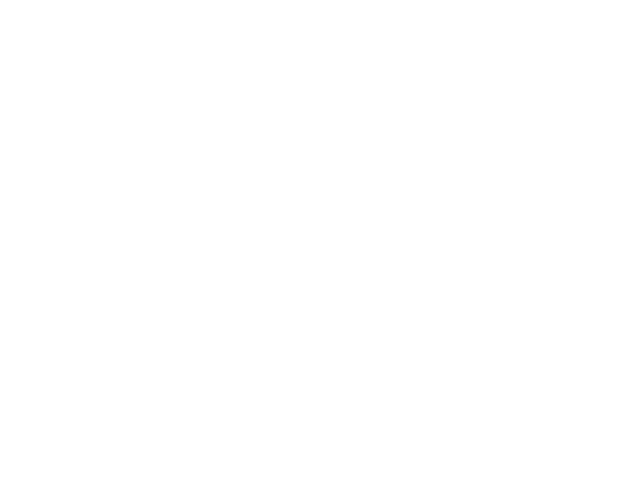

In [10]:
import os
import numpy as np
import pynoisy
import xarray as xr
from pynoisy.inverse import *
from pynoisy import utils
from joblib import Parallel, delayed
import scipy as sci
from scipy.sparse.linalg import lsqr


def compute_gradient(solver, forward, adjoint, dx=1e-2):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=solver.params.num_unknowns)
    for n, (i, j) in enumerate(zip(*np.where(solver.params.mask))):
        solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
        source_ij = solver.get_laplacian(forward) - source
        solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
        source_ij = source_ij / dx
        gradient[n] += (adjoint * source_ij).mean()
    return gradient

def set_state(solver, state):
    solver.diffusion.spatial_angle.values[solver.params.mask] = state

def set_disk_mask(solver):
    solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
    solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data
    return solver

def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    envelope.plot(ax=ax[0])
    envelope.sel(x=0).plot(ax=ax[1])
    plt.tight_layout()

def estimate_envelope(grf, measurements, amplitude=1.0):
    num_frames = measurements.sizes['t']
    image_shape = (measurements.sizes['x'], measurements.sizes['y'])
    b = measurements.data.ravel()
    diags = np.exp(-amplitude * grf).data.reshape(num_frames, -1)
    A = sci.sparse.diags(diags, offsets=np.arange(num_frames) * -diags.shape[1],
                         shape=[diags.shape[1] * diags.shape[0], diags.shape[1]])
    sol = lsqr(A, b)[0]
    envelope = pynoisy.envelope.grid(data=sol.reshape(image_shape))
    envelope.coords['x'] = measurements.x
    envelope.coords['y'] = measurements.y
    return envelope


# Load measurements
load_path = '../runs/GRMHD/02/'
measurements = xr.load_dataarray(os.path.join(load_path,'measurements.nc'))

# Load measurements
advection = pynoisy.advection.disk()
diffusion = pynoisy.diffusion.ring(opening_angle=0.8)
solver = pynoisy.forward.NoisySolver(advection, diffusion)
solver = set_disk_mask(solver)

forward_fn = lambda source: solver.run_symmetric(source, verbose=False)
adjoint_fn = lambda source: solver.run_adjoint(source, verbose=False)
gradient_fn = lambda forward, adjoint: compute_gradient(solver, forward, adjoint)
get_state_fn = lambda: solver.diffusion.spatial_angle.values[solver.params.mask]
set_state_fn = lambda state: set_state(solver, state)

amplitude = 1.0
krylov_degree = 8
max_admm_iter = 20

run_name = 'test1'
logdir = os.path.join(load_path, run_name)
writer = SummaryWriter(logdir=logdir)
writer.average_image('average_frame/measurements', measurements)
callback_fn = [
    CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
    CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration)),
]
forward_op = ForwardOperator.krylov(
    forward_fn, adjoint_fn, gradient_fn, set_state_fn, get_state_fn, measurements, krylov_degree
)

options = {'maxiter': 10000, 'maxls': 100, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-16}
state = forward_op.get_state()

In [11]:
envelope = estimate_envelope(forward_op(state), measurements, amplitude)

In [12]:
measurements_grf = np.log(
    envelope.where(envelope > 0) /
    measurements.where(measurements > 0)).transpose('t', 'x', 'y', transpose_coords=False).fillna(0.0)

<IPython.core.display.Javascript object>


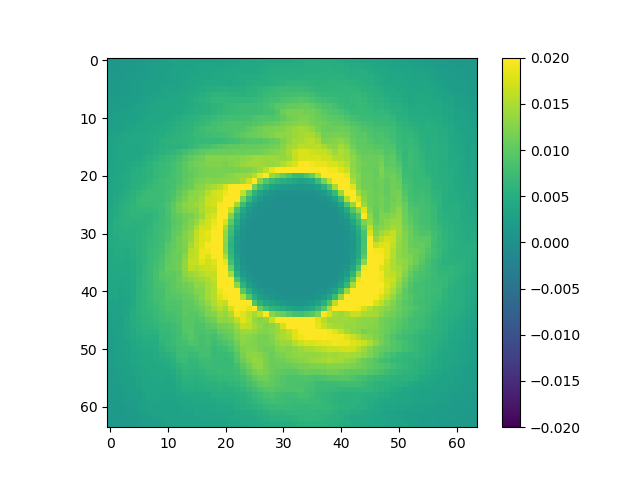

In [35]:
%matplotlib notebook
measurements1.noisy_methods.get_animation(vmin=-0.02, vmax=0.02)

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


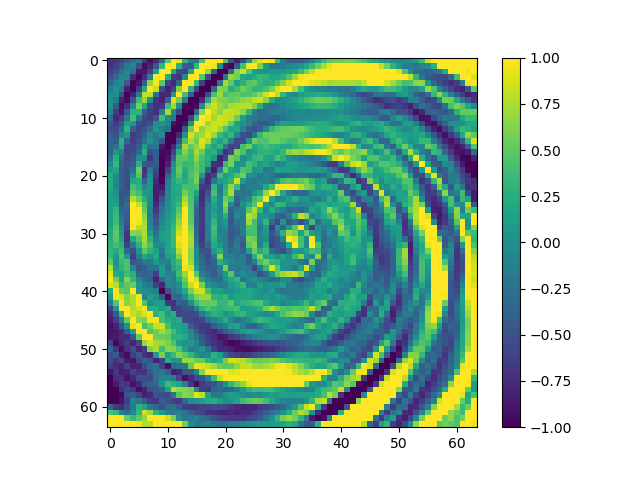

In [36]:
%matplotlib notebook
measurements_grf.noisy_methods.get_animation(vmin=-1, vmax=1)

In [28]:
load_path =  '../runs/full_opt/'
measurements1 = xr.load_dataarray(os.path.join(load_path,'measurements.nc'))

In [39]:
advection = pynoisy.advection.disk(direction='ccw')
diffusion = pynoisy.diffusion.ring(opening_angle=-0.8)
solver = pynoisy.forward.NoisySolver(advection, diffusion)
meas = solver.run_symmetric()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


In [20]:
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
random_field = solver.run_symmetric()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.96s/it]
